<a href="https://colab.research.google.com/github/varun-affinsys/Monocular-Depth-Estimation-with-Transfer-Learning-pretrained-MobileNetV2/blob/master/Monocular_Depth_Estimation_with_Transfer_Learning_pretrained_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
import cv2

from UtilityTest import DepthDataset
from UtilityTest import ToTensor

In [2]:
from zipfile import ZipFile
zf = ZipFile('/content/imgs.zip', 'r')
zf.extractall('/content/imgs')
zf.close()

In [3]:
#location of images
loc_img= '/content/imgs/imgs'

0 (640, 480)
1 (640, 480)
2 (640, 480)
3 (640, 480)
4 (640, 480)
5 (640, 480)
6 (620, 480)


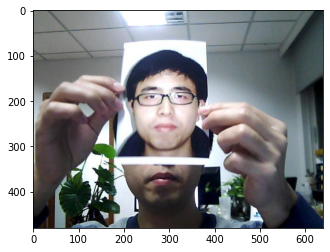

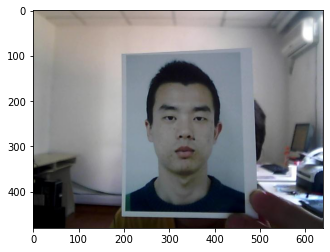

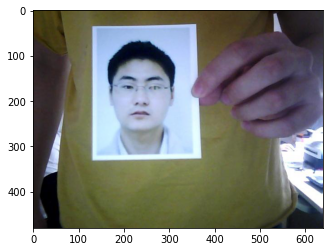

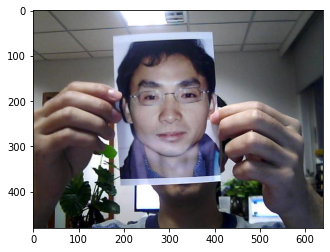

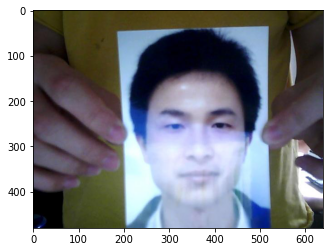

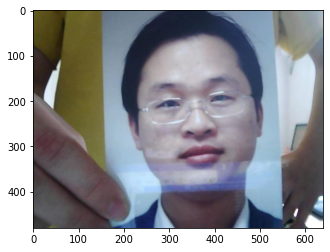

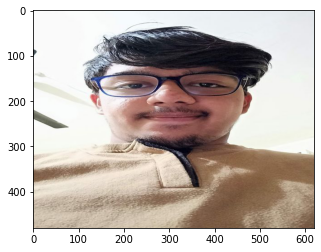

<Figure size 432x288 with 0 Axes>

In [4]:
depth_dataset = DepthDataset(root_dir=loc_img)
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]
    print(i, sample['image'].size)
    plt.imshow(sample['image'])
    plt.figure()

    if i == 6:
        plt.show()
        break

In [5]:
depth_dataset = DepthDataset(root_dir=loc_img,transform=transforms.Compose([ToTensor()]))
batch_size=1
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size)
dataiter = iter(train_loader)
images = dataiter.next()

In [6]:
#importing the model 
from Mobile_model import Model

In [7]:
!nvidia-smi

Tue Sep 21 11:23:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import torch
torch.cuda.is_available()

True

In [9]:
model = Model().cuda()
model = nn.DataParallel(model)
#load the trained model
model.load_state_dict(torch.load('/content/10.pth'))
model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

DataParallel(
  (module): Model(
    (encoder): Encoder(
      (original_model): MobileNetV2(
        (features): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): InvertedResidual(
            (conv): Sequential(
              (0): ConvBNActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU6(inplace=True)
              )
              (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (2): InvertedRe

In [10]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [11]:
os.mkdir('/content/generated_img')

In [12]:
#Upscaling image and saving the image
for i,sample_batched1  in enumerate (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    outtt=model(image1 )
    x=outtt.detach().cpu().numpy()
    img=x.reshape(240,320)
    scale_percent = 200 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    plt.imsave('generated_img/%d_depth.jpg' %i, resized, cmap='inferno') 
    
    s_img=sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0)
    plt.imsave('generated_img/%d_image.jpg' %i, s_img) 

In [13]:
import zipfile
zf = zipfile.ZipFile("myzipfile.zip", "w")
for dirname, subdirs, files in os.walk("generated_img"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()